# A Steam reviews classifier using Naive Bayes

<div style="text-align: justify">
Steam is a digital platform for the purchase of video games online. It is run by video game developer Valve.

Steam is one of the main options for purchasing video games online and has millions of active users every month.

One of the most important features of Steam is its review system. This system helps the user to decide whether to buy a game or not based on the experiences and recommendations of buyers of the game.

The review system classifies reviews as positive or negative, and cumulative reviews are classified as overhwelmingly positive, very positive, mostly positive, positive, mixed, overhwelmingly negative, very negative, mostly negative and negative.

</div>

This notebook presents step by step how to build a review classifier system using the **Naïve Bayes algorithm**.

# Importing dataset
The data to train the model were obtained from the "Steam Reviews" (Sobkowicz A., 2017) dataset available in Kaggle.

In [1]:
import pandas as pd

steam_reviews = pd.read_csv('/kaggle/input/steam-reviews/dataset.csv') 

In [2]:
steam_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


# Exploratory data analysis

Once, we have imported the dataset is time to analyze the features and their content starting from the features names.

In [3]:
list(steam_reviews.columns)

['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']

- app_id: Game ID.
- app_name: Game name.
- review_text: Text of the review.
- review_score: Whether the review recommends the game or not.
- review_votes: Whether the review was recommended by another user or not.

Possible values of column "review_score".

In [4]:
list(pd.unique(steam_reviews['review_score']))

[1, -1]

We can see the positive reviews are recorded with a value of 1 and negative reviews are recorded with a value of -1.

Let's explore the number of games.

In [5]:
games = pd.unique(steam_reviews['app_name'])
games_count = len(games)
games_count

9364

Now, I will randomly select ten games to analyze and classify their reviews.

In [6]:
import numpy as np

np.random.seed(2810)
sample_size = 10

sampled_id = np.random.randint(0, games_count, sample_size)

sampled_games = list(games[sampled_id])
sampled_games

['Metro: Last Light Redux',
 'Metro 2033 Redux',
 'Rust',
 'Oozi: Earth Adventure',
 'Men of War: Vietnam',
 'Watch_Dogs',
 'Ostrich Island',
 'Mysterious Castle',
 'Air Brawl',
 'Death and the Fly']

Count number of reviews per game

In [7]:
games_data = steam_reviews.query("app_name in @sampled_games")

Let's explore the number of positive and negative reviews in subset.

In [8]:
vc = games_data['review_score'].value_counts().reset_index(name='count')
vcn = games_data['review_score'].value_counts(normalize=True).reset_index(name='proportion')

review_score_stats = pd.merge(vc, vcn, on='index')
review_score_stats.rename(columns={'index': 'review_score'}, inplace=True)
review_score_stats

,review_score,count,proportion
0,1,73324,0.780549
1,-1,20615,0.219451


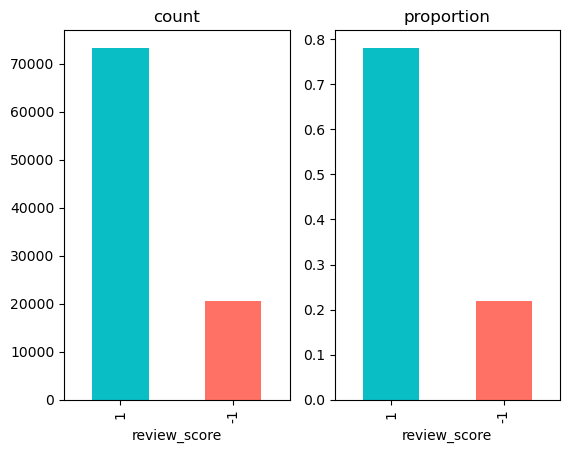

In [9]:
import matplotlib.pyplot as plt

kind = 'bar'
bar_color = ["#09BEC5", "#FF7065"]

fig, axes = plt.subplots(nrows=1,ncols=2)

review_score_stats.plot(x='review_score', 
                        y='count', 
                        ax = axes[0], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True,
                        legend=False)

review_score_stats.plot(x='review_score', 
                        y='proportion', 
                        ax = axes[1], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True, 
                        legend=False)

plt.show()

Rows per game

In [10]:
games_rows = games_data.groupby('app_name').size()
games_rows

app_name
Air Brawl                    557
Death and the Fly              7
Men of War: Vietnam          250
Metro 2033 Redux            4250
Metro: Last Light Redux     3233
Mysterious Castle              8
Oozi: Earth Adventure        204
Ostrich Island               132
Rust                       77037
Watch_Dogs                  8261
dtype: int64

Review score absolute frequencies and relative frequencies by game

In [11]:
import numpy as np

neg_freq = games_data.groupby('app_name').apply(lambda x: (x['review_score']==-1).sum()).reset_index(name='neg_freq')
pos_freq = games_data.groupby('app_name').apply(lambda x: (x['review_score']==1).sum()).reset_index(name='pos_freq')

# Joining absolute frequencies columns
games_reviews_freqs = neg_freq.join(pos_freq['pos_freq'])

neg_rel_freq = games_reviews_freqs.groupby('app_name').apply(lambda x: x['neg_freq']/(x['neg_freq'] + x['pos_freq'])).reset_index(name='neg_rel_freq')
pos_rel_freq = games_reviews_freqs.groupby('app_name').apply(lambda x: x['pos_freq']/(x['neg_freq'] + x['pos_freq'])).reset_index(name='pos_rel_freq')

# Joining relative frequencies columns
games_reviews_rel_freqs = neg_rel_freq.join(pos_rel_freq['pos_rel_freq'])
games_reviews_rel_freqs = games_reviews_rel_freqs.loc[:, games_reviews_rel_freqs.columns != 'level_1']

# Joining absolute frequency columns and relative frequency columns
games_reviews_freqs = games_reviews_freqs.join(games_reviews_rel_freqs[['neg_rel_freq', 'pos_rel_freq']])
games_reviews_freqs

,app_name,neg_freq,pos_freq,neg_rel_freq,pos_rel_freq
0,Air Brawl,138,419,0.247756,0.752244
1,Death and the Fly,5,2,0.714286,0.285714
2,Men of War: Vietnam,108,142,0.432000,0.568000
3,Metro 2033 Redux,559,3691,0.131529,0.868471
4,Metro: Last Light Redux,302,2931,0.093412,0.906588
5,Mysterious Castle,6,2,0.750000,0.250000
6,Oozi: Earth Adventure,37,167,0.181373,0.818627
7,Ostrich Island,16,116,0.121212,0.878788
8,Rust,16005,61032,0.207757,0.792243
9,Watch_Dogs,3439,4822,0.416293,0.583707


### Absolute frequencies barplot

<AxesSubplot:ylabel='app_name'>

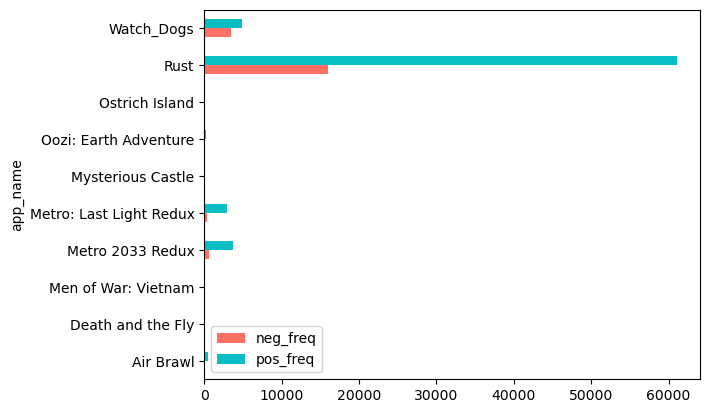

In [12]:
games_reviews_freqs.plot(x="app_name", y=["neg_freq", "pos_freq"], kind="barh", color=["#FF7065", "#09BEC5"])

### Relative frequencies barplot

<AxesSubplot:ylabel='app_name'>

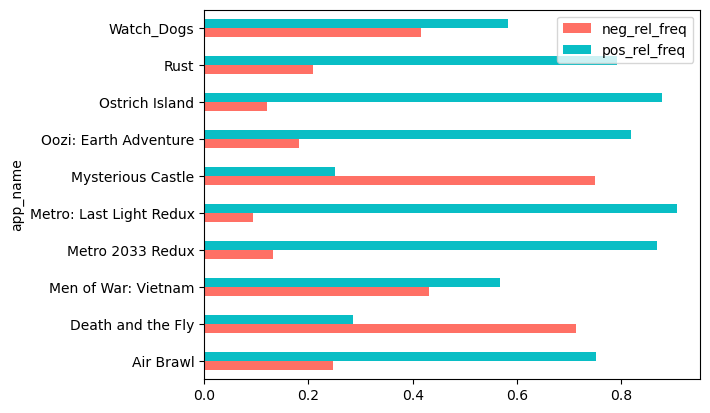

In [13]:
games_reviews_freqs.plot(x="app_name", y=["neg_rel_freq", "pos_rel_freq"], kind="barh", color=["#FF7065", "#09BEC5"])

# Preparing data

<div style="text-align: justify">
Before creating the model and training it, we must preprocess the text of the reviews. This is in order to reduce the amount of data needed to train the model and improve the accuracy of the model.
</div>

### Preprocessing steps
- Lowercase
- Remove punctuation
- Remove stop words
- Stemming
- Tokenize sentences


In [14]:
import sys
sys.path.insert(1, "/kaggle/input/contraction-map")

In [15]:
from contractions import CONTRACTION_MAP
import re

"""
Open source code from Sarkar (2018)
Sarkar, D (2018, 3 agosto). 
Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP. KDnuggets. 
Recuperado 6 de marzo de 2023, de https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
"""

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [29]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import string

def preprocess_review(review):
    """
    Input
    review: Review text (string)
    -----------------------------------
    Output
    preprocessed_review: List of tokens from 
    preprocessed review text (list of strings)
    """
    review = review.lower() # Lowecase
    
    # Expand contractions so as not to lose relevant information
    review = expand_contractions(review) 
    
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')

    # Tokenization without stopwords
    review_tokens = word_tokenize(review)
    review_tokens = [word for word in review_tokens if not word in all_stopwords]
    
    ps = PorterStemmer()
    
    # Stemming
    review_tokens = [ps.stem(word) for word in review_tokens]
    
    preprocessed_review = review_tokens
    
    return preprocessed_review

In [32]:
preprocess_review("This will be more of a ''my experience with this game'' type of review, because saying things like")

['experi', 'game', 'type', 'review', 'say', 'thing', 'like']